<a href="https://colab.research.google.com/github/krishshhah/Gold-Prices-Predictor-LTSM-NN/blob/main/Stock_Predictor_LSTM_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from numpy import lib
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.metrics import classification_report, f1_score

In [54]:
ticker_symbol = 'GC=F'  # Gold prices

# Get the data
stock_data = yf.Ticker(ticker_symbol)

# Fetch historical market data
df = stock_data.history(period="6mo")  # Last 5 years data

In [55]:
df.sort_index(ascending=False, inplace=True)

df['Price_change'] = df['Close']-df['Open']
df['Prev_price_change'] = df['Price_change'].shift(-1)
df['Prev_5d_price_change'] = df['Price_change'].shift(-5)
df['Prev_10d_price_change'] = df['Price_change'].shift(-10)
df['Prev_open'] = df['Open'].shift(-1)
df['Prev_high'] = df['High'].shift(-1)
df['Prev_low'] = df['Low'].shift(-1)
df['Prev_close'] = df['Close'].shift(-1)
df['Prev_volume'] = df['Volume'].shift(-1)


df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends','Stock Splits'])
df['Curr_weekday'] = df.index.dayofweek

print(df.head())

                                 Close  Price_change  Prev_price_change  \
Date                                                                      
2025-04-23 00:00:00-04:00  3291.399902    -76.300049         -21.399902   
2025-04-22 00:00:00-04:00  3400.800049    -21.399902          64.000000   
2025-04-21 00:00:00-04:00  3406.199951     64.000000         -36.300049   
2025-04-17 00:00:00-04:00  3308.699951    -36.300049          88.300049   
2025-04-16 00:00:00-04:00  3326.600098     88.300049           2.699951   

                           Prev_5d_price_change  Prev_10d_price_change  \
Date                                                                     
2025-04-23 00:00:00-04:00              2.699951             -25.600098   
2025-04-22 00:00:00-04:00            -10.699951             -65.099854   
2025-04-21 00:00:00-04:00             40.099854             -98.500000   
2025-04-17 00:00:00-04:00             81.300049             -53.000000   
2025-04-16 00:00:00-04:00     

In [56]:
def calc_rsi(dataframe, col, period=14):  # default is 14, but can be specified
    delta = dataframe[col]

    gain = (delta.where(delta > 0, 0).rolling(window=period).mean())
    loss = (-delta.where(delta < 0, 0).rolling(window=period).mean())

    rs = gain / loss
    # rs = rs.fillna(0)

    rsi = 100 - (100 / (1 + rs))

    return rsi

In [57]:
def calc_sma(dataframe, col, period=14):
    # Calculate Simple Moving Average (SMA)
    sma = dataframe[col].rolling(window=period).mean()
    # sma = sma.fillna(0)
    return sma

In [58]:
def calc_ema(dataframe, col, period=14):
    """Calculate Exponential Moving Average (EMA) for a specified column."""
    ema = dataframe[col].ewm(span=5, adjust=False).mean()
    #ema = dataframe[col].ewm(com=0.4).mean()
    return ema

In [59]:
def calc_macd(dataframe, col, short_window=12, long_window=26, signal_window=9):
    short_ema = dataframe[col].ewm(span=short_window, adjust=False).mean()
    long_ema = dataframe[col].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

In [60]:
feature_names = ['Prev_5d_price_change', 'Prev_10d_price_change']
for x in [14, 30]:
    df['Prev_SMA' + str(x)] = calc_sma(df, 'Prev_close', x)
    df['Prev_RSI' + str(x)] = calc_rsi(df, 'Prev_price_change', x)
    feature_names = feature_names + ['Prev_SMA' + str(x), 'Prev_RSI' + str(x)]
    #df['Prev_EMA' + str(x)] = calc_rsi(df, 'Close', x)
#df['Prev_EMA' + str(x)] = calc_rsi(df, 'Prev_close', x)

df['MACD'], df['MACD_Signal'] = calc_macd(df, 'Prev_close')
feature_names += ['MACD', 'MACD_Signal']

df = df.dropna()
print(df.head())

                                 Close  Price_change  Prev_price_change  \
Date                                                                      
2025-03-12 00:00:00-04:00  2939.100098     27.100098          28.500000   
2025-03-11 00:00:00-04:00  2912.899902     28.500000         -19.100098   
2025-03-10 00:00:00-04:00  2891.000000    -19.100098           3.800049   
2025-03-07 00:00:00-05:00  2904.699951      3.800049          12.600098   
2025-03-06 00:00:00-05:00  2916.600098     12.600098          -1.399902   

                           Prev_5d_price_change  Prev_10d_price_change  \
Date                                                                     
2025-03-12 00:00:00-04:00             -1.399902               3.300049   
2025-03-11 00:00:00-04:00             23.500000             -34.199951   
2025-03-10 00:00:00-04:00             17.500000              14.799805   
2025-03-07 00:00:00-05:00            -40.300049              -1.199951   
2025-03-06 00:00:00-05:00     

In [61]:
def regressor(dates, prices, reg='l', poly=2):
    if reg == 'l':
        m, c, r, p, std_err = stats.linregress(dates, prices)
        my_model = m * dates + c
        plt.plot(dates, my_model, label='Linear Regression Line', color='orange')
        print(f"Regression Line Equation: y = {m:.4f}x + {c:.4f}") # prints out the regression function
    elif reg == 'p':
        my_model = np.poly1d(np.polyfit(dates, prices, poly))
        my_line = np.linspace(1, 1800, 100)
        plt.plot(my_line, my_model(my_line), label='Polynomial Regression Line', color='orange')
    r_value, p_value = pearsonr(dates, prices)
    print(f"Correlation coefficient (r): {r_value:.3f}")

In [62]:
def plot_rsi(df, period=30, date='2018-12-31'):
    change = df.copy()
    change['DateNumeric'] = (change.index - change.index.min()).days
    dates_numeric = change['DateNumeric']

    plt.clf()
    plt.plot(dates_numeric, change['Prev_RSI' + str(period)])
    plt.axhline(y=30, color='red', linestyle='--', label='Oversold Level (30)')
    plt.axhline(y=70, color='green', linestyle='--', label='Overbought Level (70)')
    plt.xlabel('Days since ' + str(date))  # scales x-axis
    plt.ylabel('Value')  # scales y-axis
    plt.title('RSI of ' + str(ticker_symbol) + ' shares (' + str(period) + '-day period)')
    plt.legend()
    plt.show()

In [63]:
def price_plot(type='l', poly=2, sma_period=30, rsi_period=30, date='2018-12-31'):  # input a date - 2018-01-01
    change = df.copy()

    if change.empty:
        print(f"No data available after {date}.")
        return

    change['DateNumeric'] = (change.index - change.index.min()).days
    prices = change['Prev_close']
    dates_numeric = change['DateNumeric']
    price_change = change['Prev_price_change']

    print("Number of data points:", len(prices))  # Check number of data points
    print("Max price = ", max(prices))
    print("Min price = ", min(prices))
    print("Avg price change = ", np.mean(price_change))

    plt.plot(dates_numeric, change['Prev_SMA' + str(sma_period)], label=str(sma_period) + '-day SMA', color='red')

    plt.plot(dates_numeric, prices, label=str(ticker_symbol) + ' Close Price', color='blue')
    plt.xlabel('Days since ' + str(date))  # scales x-axis
    plt.ylabel('%/Share')  # scales y-axis
    plt.title('Closing price of ' + str(ticker_symbol)+ ' shares')

    # Plot the regression line
    regressor(dates_numeric, prices, type, poly)

    plt.legend()
    plt.show()

    plot_rsi(change, rsi_period, date)


Number of data points: 86
Max price =  2947.89990234375
Min price =  2565.699951171875
Avg price change =  1.9244186046511629
Regression Line Equation: y = 2.7479x + 2566.2422
Correlation coefficient (r): 0.869


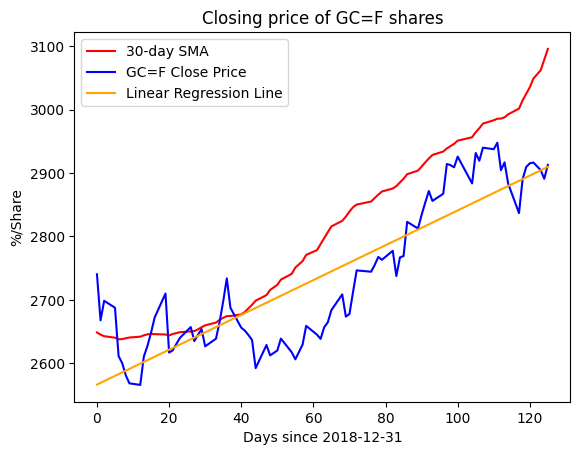

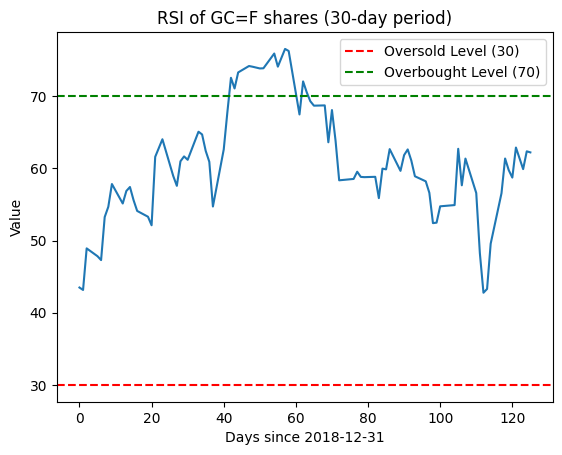

In [64]:
price_plot()

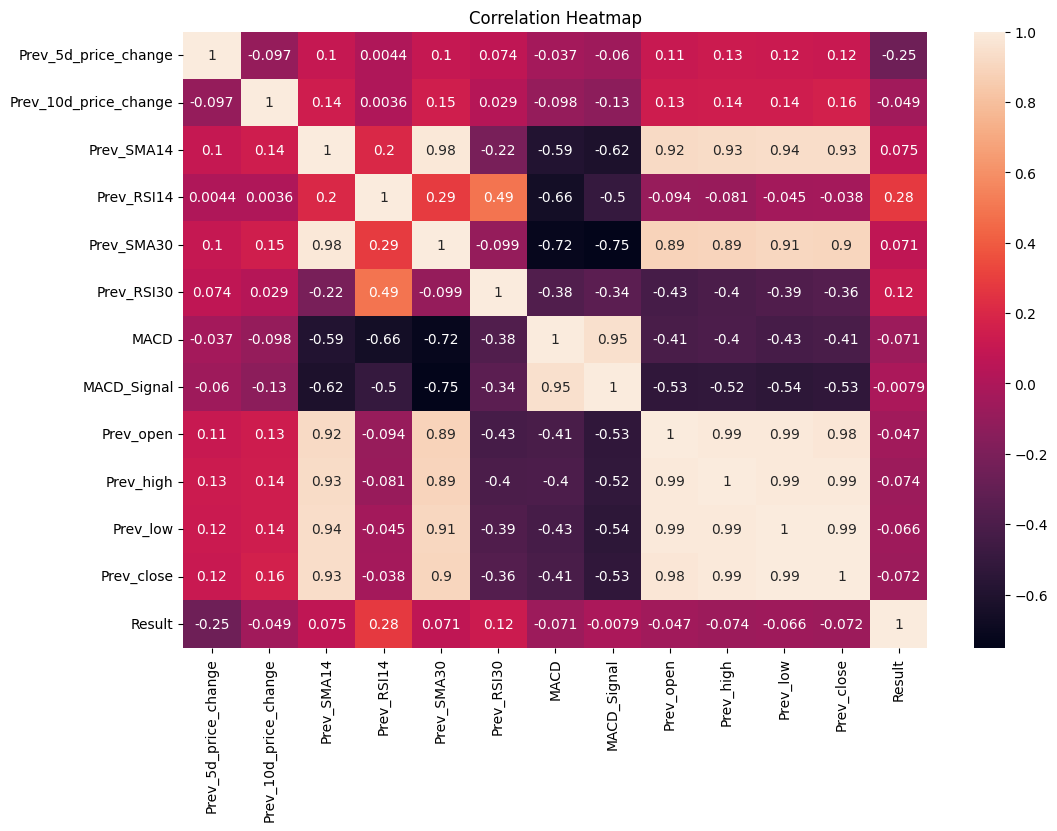

                                 Close  Price_change  Prev_price_change  \
Date                                                                      
2025-03-12 00:00:00-04:00  2939.100098     27.100098          28.500000   
2025-03-11 00:00:00-04:00  2912.899902     28.500000         -19.100098   
2025-03-10 00:00:00-04:00  2891.000000    -19.100098           3.800049   
2025-03-07 00:00:00-05:00  2904.699951      3.800049          12.600098   
2025-03-06 00:00:00-05:00  2916.600098     12.600098          -1.399902   
...                                ...           ...                ...   
2024-11-12 00:00:00-05:00  2600.000000     -5.500000         -60.500000   
2024-11-11 00:00:00-05:00  2611.199951    -60.500000          -1.000000   
2024-11-08 00:00:00-05:00  2687.500000     -1.000000          35.899902   
2024-11-07 00:00:00-05:00  2698.399902     35.899902         -66.899902   
2024-11-06 00:00:00-05:00  2667.600098    -66.899902          -2.699951   

                        

In [65]:
df['Result'] = df['Price_change'].apply(lambda x: 1 if x > 0 else 0)

feature_names = feature_names + ['Prev_open', 'Prev_high', 'Prev_low', 'Prev_close']
features = df[feature_names]
targets = df['Result']
feature_target_df = df[feature_names + ['Result']]

corr = feature_target_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

print(df)

In [66]:
#train, test, split: set features (X) and targets (y)
df.index = df.index.date
X = df.drop(['Result', 'Price_change', 'Close'], axis = 1) # selects only the targets, axis (columns)
y = df['Result']

#convert to numpy arrays
X = X.values
y = y.values

scaler = StandardScaler()
X = scaler.fit_transform(X)  # Normalize features

In [67]:
# Create a model class to inherit the nn.Module
class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_size=15, hidden_layer_size=100, output_size=1, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)  # *2 for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the last time step's output
        predictions = self.sigmoid(self.linear(lstm_out))
        return predictions

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 96) #80% train, 20% test

In [70]:
X_train = torch.FloatTensor(X_train) # converts numpy arrays to floatTensors (all features are decimals)
X_test = torch.FloatTensor(X_test)

In [71]:
y_train = torch.FloatTensor(y_train).view(-1, 1) # converts numpy arrays to longTensors (all targets are integers)
y_test = torch.FloatTensor(y_test).view(-1, 1)

In [72]:
print(f"Number of features: {X_train.shape[1]}")


Number of features: 15


In [73]:
# Create random seed for randomisation
torch.manual_seed(55)
input_size = X_train.shape[1]
model = AdvancedLSTMModel(input_size=input_size, hidden_layer_size=128, num_layers=2, dropout=0.3)

In [74]:
# set a criterion of the model to measure the error, to measure how far off the predictions are from the actual data
criterion = nn.BCELoss()
# choose an optimiser - using Adam optimiser, lr (learning rate) = if learning rate does not go down through each iteration, it should be lowered to learn slower
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)



In [75]:
# Train model, determining how many epochs needed. Epoch = 1 run through the entire network
epochs = 1000
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train.unsqueeze(1))  # Add sequence dimension for LSTM
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update learning rate

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6987981796264648
Epoch 100, Loss: 0.1806589961051941
Epoch 200, Loss: 0.14011341333389282
Epoch 300, Loss: 0.13597166538238525
Epoch 400, Loss: 0.1331225037574768
Epoch 500, Loss: 0.13328778743743896
Epoch 600, Loss: 0.13633649051189423
Epoch 700, Loss: 0.13349249958992004
Epoch 800, Loss: 0.13433563709259033
Epoch 900, Loss: 0.13478237390518188


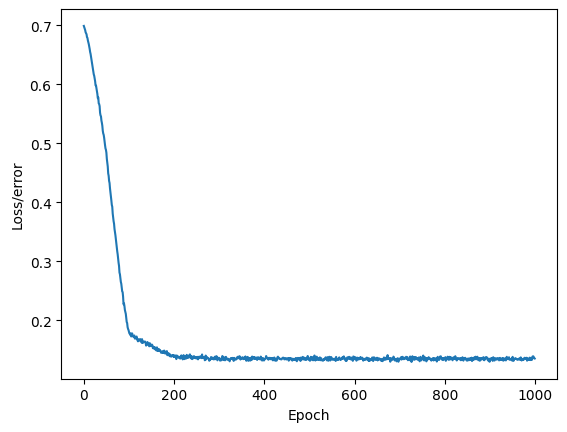

In [76]:
# Graphing out the losses
plt.plot(range(epochs), losses) # y-axis = losses
plt.ylabel("Loss/error")
plt.xlabel("Epoch")
plt.show()

In [77]:
correct = 0
model.eval()
with torch.no_grad():
  y_eval = model(X_test.unsqueeze(1))
  loss = criterion(y_eval, y_test)
  print(f'Test Loss: {loss.item()}')

  y_pred_class = (y_eval >= 0.5).float()
  # Calculate accuracy
  correct = (y_pred_class.numpy() == y_test.numpy()).sum()  # Count correct predictions
  accuracy = correct / y_test.size(0) * 100  # Calculate accuracy percentage

  print(f'Accuracy: {accuracy:.2f}%')

  print(classification_report(y_test.numpy(), y_pred_class.numpy()))
  print(f'F1 Score: {f1_score(y_test.numpy(), y_pred_class.numpy()):.4f}')


Test Loss: 0.805591344833374
Accuracy: 83.33%
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84         8
         1.0       1.00      0.70      0.82        10

    accuracy                           0.83        18
   macro avg       0.86      0.85      0.83        18
weighted avg       0.88      0.83      0.83        18

F1 Score: 0.8235


In [78]:
loss

tensor(0.8056)